# <b><i>Modelo de Regressão Linear<br> </b>Consumo de Cerveja</i>

### Variáveis:
* **Data:** Data do registro
* **Temperatura_Media:** Temperatura média
* **Temperatura_Minima:** Temperatura mínima
* **Temperatura_Maxima:** Temperatura máxima
* **Precipitação:** Hidrometeoros (Chuva, Neve, Chuvisco, etc) que caem das nuvens em direção ao solo.
* **Final_de_Semana:** Final de semana (Sim ou Não)
* **Consumo:** Quantidade de consumo

Importação das bibliotécas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import shapiro, pearsonr, spearmanr, kendalltau
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Configurações para os gráficos

In [19]:
plot_config= {
        "axes.spines.top": False,       # Remover borda superior
        "axes.spines.right": False,     # Remover borda direita
        "axes.grid": False,             # Remover grades
        "figure.figsize": (15, 6)       # Tamanho padrão da figura
}
sns.set_theme(rc= plot_config)

Carga dos dados e configuração para exibição numérica

In [3]:
df = pd.read_csv("data/consumo_cerveja.csv")
pd.options.display.float_format = '{:.2f}'.format

df.head(3)

,Data,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana,Consumo
0,01/01/2015,27.30,23.90,32.50,0.00,0,25.46
1,02/01/2015,27.02,24.50,33.50,0.00,0,28.97
2,03/01/2015,24.82,22.40,29.90,0.00,1,30.81


Quantidade de dados nulos para cada variável

In [4]:
df.isna().sum()

Data                  0
Temperatura_Media     0
Temperatura_Minima    0
Temperatura_Maxima    0
Precipitacao          0
Final_de_Semana       0
Consumo               0
dtype: int64

Tipo dos dados

In [5]:
df.dtypes

Data                   object
Temperatura_Media     float64
Temperatura_Minima    float64
Temperatura_Maxima    float64
Precipitacao          float64
Final_de_Semana         int64
Consumo               float64
dtype: object

Analise descritiva das medidas de tendencia central

In [6]:
df.describe()

,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana,Consumo
count,365.00,365.00,365.00,365.00,365.00,365.00
mean,21.23,17.46,26.61,5.20,0.28,25.40
std,3.18,2.83,4.32,12.42,0.45,4.40
min,12.90,10.60,14.50,0.00,0.00,14.34
25%,19.02,15.30,23.80,0.00,0.00,22.01
50%,21.38,17.90,26.90,0.00,0.00,24.87
75%,23.28,19.60,29.40,3.20,1.00,28.63
max,28.86,24.50,36.50,94.80,1.00,37.94


Visualização para análise de outliers

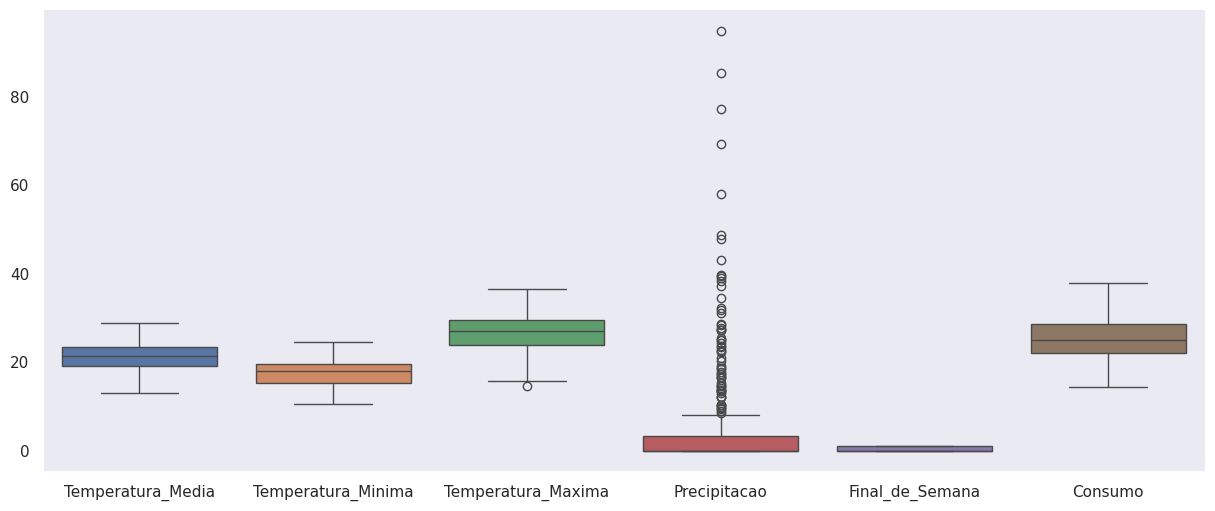

In [20]:
sns.boxplot(df);

Teste de normalidade das variáveis.<br>
Um valor de p <= 0.05 rejeitamos a hipótese nula,<br>
ou seja, os dados não possuem distribuição normal.

In [21]:
df = df.drop("Data", axis=1)

print("Teste de Normalidade (Shapiro-Wilk):\n")
for col in df.columns:
  stat, p = shapiro(df[col])
  print(f"{col}: stat= {stat:.4f}, p= {p:.4f}")

Teste de Normalidade (Shapiro-Wilk):

Temperatura_Media: stat= 0.9915, p= 0.0341
Temperatura_Minima: stat= 0.9843, p= 0.0005
Temperatura_Maxima: stat= 0.9929, p= 0.0835
Precipitacao: stat= 0.4832, p= 0.0000
Final_de_Semana: stat= 0.5654, p= 0.0000
Consumo: stat= 0.9886, p= 0.0058


### Correlação de Pearson
O **Coeficiente de Correlação de Pearson** mede a **força** e a **direção** da relação linear entre duas variáveis quantitativas. Ele assume que as variáveis têm uma distribuição normal.

- **Quando usar**: Pearson é utilizado quando as variáveis têm uma relação linear e ambas seguem uma **distribuição normal**.

Onde $ r $ varia entre -1 e 1:
  - $ r = 1 $: Correlação positiva perfeita
  - $ r = -1 $: Correlação negativa perfeita
  - $ r = 0 $: Sem correlação linear

In [22]:
corr_pearson = df.corr(method="pearson")
corr_pearson

,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana,Consumo
Temperatura_Media,1.00,0.86,0.92,0.02,-0.05,0.57
Temperatura_Minima,0.86,1.00,0.67,0.10,-0.06,0.39
Temperatura_Maxima,0.92,0.67,1.00,-0.05,-0.04,0.64
Precipitacao,0.02,0.10,-0.05,1.00,0.00,-0.19
Final_de_Semana,-0.05,-0.06,-0.04,0.00,1.00,0.51
Consumo,0.57,0.39,0.64,-0.19,0.51,1.00


### Correlação de Spearman
O **Coeficiente de Spearman** mede a relação **monotônica** entre duas variáveis, o que significa que, à medida que uma variável aumenta, a outra também aumenta ou diminui, mas não necessariamente de forma linear.

- **Quando usar**: Use Spearman quando os dados não forem normalmente distribuídos ou se a relação entre as variáveis for **monotônica** (não linear).
- Baseia-se no ranking das variáveis.

In [23]:
corr_spearman = df.corr(method='spearman')
corr_spearman

,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana,Consumo
Temperatura_Media,1.00,0.86,0.91,0.02,-0.04,0.57
Temperatura_Minima,0.86,1.00,0.66,0.17,-0.05,0.39
Temperatura_Maxima,0.91,0.66,1.00,-0.12,-0.02,0.64
Precipitacao,0.02,0.17,-0.12,1.00,0.00,-0.17
Final_de_Semana,-0.04,-0.05,-0.02,0.00,1.00,0.50
Consumo,0.57,0.39,0.64,-0.17,0.50,1.00


### Correlação de Kendall
O **Coeficiente de Kendall** é outra medida não paramétrica que mede a associação entre duas variáveis. Ele leva em consideração a concordância entre pares de observações.

- **Quando usar**: Utilize Kendall quando o número de dados é pequeno, ou quando há muitos empates nos dados.
- Baseia-se na concordância e discordância de pares ordenados.

In [24]:
corr_kendall = df.corr(method='kendall')
corr_kendall

,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana,Consumo
Temperatura_Media,1.00,0.68,0.75,0.01,-0.03,0.40
Temperatura_Minima,0.68,1.00,0.48,0.12,-0.04,0.27
Temperatura_Maxima,0.75,0.48,1.00,-0.09,-0.02,0.46
Precipitacao,0.01,0.12,-0.09,1.00,0.00,-0.13
Final_de_Semana,-0.03,-0.04,-0.02,0.00,1.00,0.41
Consumo,0.40,0.27,0.46,-0.13,0.41,1.00


### As três variáveis preditoras de maior correlação com a variável alvo

In [26]:
top_corr = corr_pearson["Consumo"].drop("Consumo").abs().nlargest(3)
print(top_corr.index.tolist(), "\n")
print(top_corr)

['Temperatura_Maxima', 'Temperatura_Media', 'Final_de_Semana'] 

Temperatura_Maxima   0.64
Temperatura_Media    0.57
Final_de_Semana      0.51
Name: Consumo, dtype: float64


### Teste de Hipótese para correlação entre variável preditora de maior correlação e variável alvo

- H0: rho = 0 (sem correlação)
- H1: rho ≠ 0

In [27]:
r, p_valor = pearsonr(df[top_corr.index[0]], df["Consumo"])
print(f"Pearson r = {r:.4f}, p = {p_valor:.4f}")

r, p_valor = spearmanr(df[top_corr.index[0]], df["Consumo"])
print(f"Spearman r = {r:.4f}, p = {p_valor:.4f}")

r, p_valor = kendalltau(df[top_corr.index[0]], df["Consumo"])
print(f"Kendall tau = {r:.4f}, p = {p_valor:.4f}")

print("\nUm p-valor <= 0,05 indica uma Correlação significativa")

Pearson r = 0.6427, p = 0.0000
Spearman r = 0.6413, p = 0.0000
Kendall tau = 0.4552, p = 0.0000

Um p-valor <= 0,05 indica uma Correlação significativa


Visualização para correlação entre a variável de maior correlação com a variável alvo

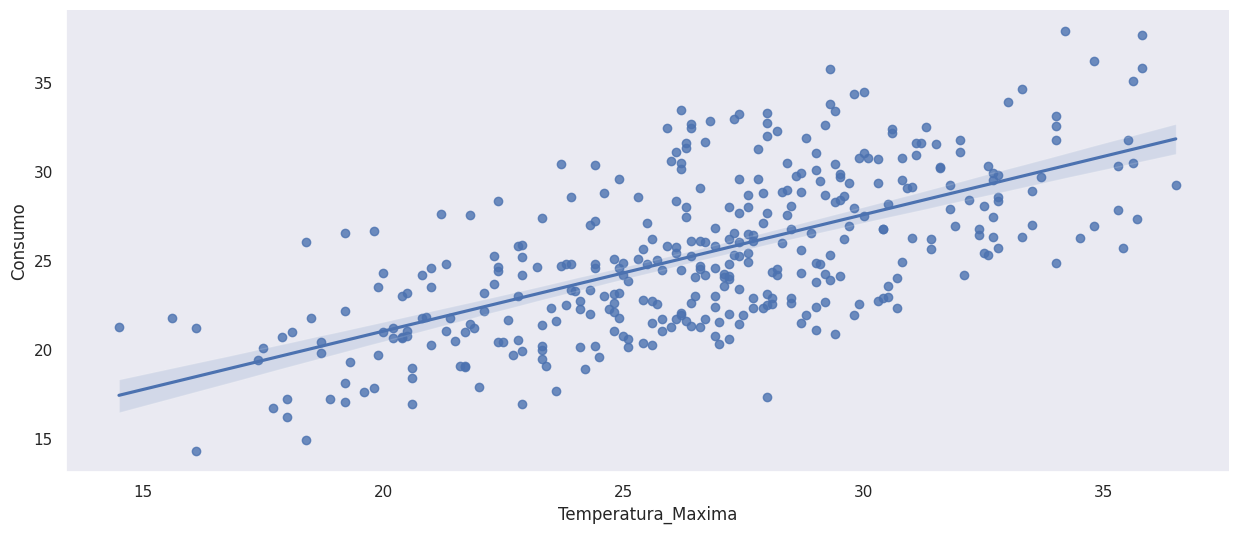

In [28]:
sns.regplot(data= df, x= top_corr.index[0], y= "Consumo");

### Ausência de Multicolinearidade
Correlação das variáveis independentes

In [29]:
independentes = df.drop("Consumo", axis=1)
independentes.corr()

,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana
Temperatura_Media,1.00,0.86,0.92,0.02,-0.05
Temperatura_Minima,0.86,1.00,0.67,0.10,-0.06
Temperatura_Maxima,0.92,0.67,1.00,-0.05,-0.04
Precipitacao,0.02,0.10,-0.05,1.00,0.00
Final_de_Semana,-0.05,-0.06,-0.04,0.00,1.00


## Escalonamento
### Padronização dos Dados

Padronização é o processo de centralizar as variáveis em torno da média e escalá-las para ter desvio padrão 1.

In [30]:
scaler = StandardScaler()
padronizadas = scaler.fit_transform(df)
padronizadas = pd.DataFrame(padronizadas, columns=df.columns)
padronizadas.head(3)

,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana,Consumo
0,1.91,2.28,1.37,-0.42,-0.63,0.01
1,1.82,2.49,1.60,-0.42,-0.63,0.81
2,1.13,1.75,0.76,-0.42,1.58,1.23


### Normalização Min-Max
A normalização Min-Max escala as variáveis para um intervalo específico, geralmente [0, 1], útil para algoritmos sensíveis à escala dos dados

In [31]:
minmax = MinMaxScaler()
normalizadas = minmax.fit_transform(df)
normalizadas = pd.DataFrame(normalizadas, columns=df.columns)
normalizadas.head(3)

,Temperatura_Media,Temperatura_Minima,Temperatura_Maxima,Precipitacao,Final_de_Semana,Consumo
0,0.90,0.96,0.82,0.00,0.00,0.47
1,0.88,1.00,0.86,0.00,0.00,0.62
2,0.75,0.85,0.70,0.00,1.00,0.70


Divisão da base - Treino e Teste

In [32]:
X = padronizadas.drop(["Consumo"], axis=1)
y = padronizadas["Consumo"]

# Separa os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

## Seleção de Variáveis
### Stepwise com AIC
**Teoria:**
**Stepwise Selection** é uma técnica que combina forward e backward selection, usando métricas como AIC.
- AIC penaliza modelos complexos.
- Permite encontrar subconjuntos de variáveis com bom poder preditivo sem overfitting.

In [33]:
def calculate_aic(model, X, y):
    n = len(y)
    k = X.shape[1] + 1  # número de parâmetros, incluindo o intercepto
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    aic = n * np.log(mse) + 2 * k
    return aic

### Implementação Stepwise Forward + Backward
Iremos criar as seguintes variáveis:

- selected_features: Lista que armazenará as variáveis selecionadas durante o procedimento.
- stepwise_model: Modelo de regressão linear a ser ajustado.
- best_aic: Variável que armazenará o menor AIC encontrado.

Seleção de variáveis com Stepwise (avançando e removendo as variáveis com base no menor AIC)

In [34]:
def forward_backward_stepwise_selection(X, y):
    selected = []
    best_aic = float('inf')
    model = LinearRegression()

    while True:
        changed = False
        candidates = [col for col in X.columns if col not in selected]
        best_candidate, best_model = None, None

        for feat in candidates:
            model.fit(X[selected + [feat]], y)
            aic = calculate_aic(model, X[selected + [feat]], y)
            if aic < best_aic:
                best_aic, best_candidate = aic, feat
                changed = True

        if changed:
            selected.append(best_candidate)
        else:
            break

    return selected

# Retorna lista de variáveis selecionadas pelo critério de AIC
selected_stepwise = forward_backward_stepwise_selection(X_train, y_train)
print("Selecionadas pelo Stepwise:", selected_stepwise)

Selecionadas pelo Stepwise: ['Temperatura_Maxima', 'Final_de_Semana', 'Precipitacao']


**Treinando modelo com variáveis selecionadas**

Ajuste do modelo Linear com as variáveis escolhidas

In [35]:
model_stepwise = LinearRegression().fit(X_train[selected_stepwise], y_train)
y_pred_stepwise = model_stepwise.predict(X_test[selected_stepwise])

**Avaliação do modelo Stepwise**

Calcular as métricas de avaliação para o modelo Stepwise

In [36]:
n = len(y_test)
k = len(selected_stepwise)
mse = mean_squared_error(y_test, y_pred_stepwise)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results = [{
    'Modelo': 'Stepwise',
    'MAE': mean_absolute_error(y_test, y_pred_stepwise),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': model_stepwise.score(X_test[selected_stepwise], y_test)
}]

pd.DataFrame(results)

,Modelo,MAE,MSE,AIC,BIC,R²
0,Stepwise,0.47,0.29,-83.48,-76.61,0.74


### SFS (Sequential Feature Selector)

O **SFS (mlxtend)** realiza seleção de variáveis de forma sequencial:
- `forward=True`: começa com nenhuma variável e vai adicionando.
- `floating=True`: permite remoção/backward no meio do processo.
- Permite validação cruzada com métrica personalizada (ex: MSE).

In [37]:
sfs_model = SFS(LinearRegression(),
                k_features='best',
                forward=True,
                floating=True,  # Ativa stepwise (entra e remove variáveis)
                scoring='neg_mean_squared_error',
                cv=5)

sfs_model.fit(X_train, y_train)
print("Variáveis selecionadas pelo SFS:", list(sfs_model.k_feature_names_))

Variáveis selecionadas pelo SFS: ['Temperatura_Maxima', 'Precipitacao', 'Final_de_Semana']


**Avaliação do modelo SFS**

In [38]:
selected_sfs = list(sfs_model.k_feature_names_)
model_sfs = LinearRegression().fit(X_train[selected_sfs], y_train)
y_pred_sfs = model_sfs.predict(X_test[selected_sfs])

n = len(y_test)
k = len(selected_sfs)
mse = mean_squared_error(y_test, y_pred_sfs)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results.append({
    'Modelo': 'SFS (mlxtend)',
    'MAE': mean_absolute_error(y_test, y_pred_sfs),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': model_sfs.score(X_test[selected_sfs], y_test)
})

pd.DataFrame(results)

,Modelo,MAE,MSE,AIC,BIC,R²
0,Stepwise,0.47,0.29,-83.48,-76.61,0.74
1,SFS (mlxtend),0.47,0.29,-83.48,-76.61,0.74


### ***Lasso (L1 Regularization)***

O **Lasso** aplica uma penalização  L1 que força alguns coeficientes a serem zero:
- Elimina variáveis irrelevantes automaticamente.
- Útil quando há muitas variáveis correlacionadas.
- O parâmetro alpha controla a intensidade da penalização.

In [39]:
alphas = np.logspace(-4, 4, 100)
lasso_cv = GridSearchCV(Lasso(), {'alpha': alphas}, cv=5)
lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.best_params_['alpha']

# Modelo final com o melhor alpha encontrado
lasso_final = Lasso(alpha=best_alpha).fit(X_train, y_train)

# Coeficientes diferentes de zero indicam variáveis selecionadas
lasso_coef = lasso_final.coef_
selected_lasso = X.columns[lasso_coef != 0]
print("Selecionadas pelo Lasso:", list(selected_lasso))

Selecionadas pelo Lasso: ['Temperatura_Maxima', 'Precipitacao', 'Final_de_Semana']


In [40]:
y_pred_lasso = lasso_final.predict(X_test)

n = len(y_test)
k = len(selected_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results.append({
    'Modelo': 'Lasso',
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': lasso_final.score(X_test, y_test)
})

### Comparando os modelos

In [41]:
results_df = pd.DataFrame(results)
print(results_df)

          Modelo  MAE  MSE    AIC    BIC   R²
0       Stepwise 0.47 0.29 -83.48 -76.61 0.74
1  SFS (mlxtend) 0.47 0.29 -83.48 -76.61 0.74
2          Lasso 0.47 0.30 -82.51 -75.64 0.74


### Conclusões Didáticas
- **Stepwise**: bom ponto de partida, mas pode gerar overfitting.
- **Lasso**: ótimo para regularização e eliminar colinearidade.
- **SFS**: flexível e robusto com validação cruzada, porém mais lento.